# Gaussian Process Regression (GPR) (a.k.a. Kriging) Introduction






This notebook covers the basics of Gaussian Process Regression (GPR), including how to construct a covariance matrix, the prior distribution, the posterior distribution, as well as making predictions using the posterior. A list of useful resources is listed at the bottom.

## The Multivariate Distribution

Let's see an example, starting with the simplest multivariate normal distribution - the bivariate normal distribution.

If we have a two-dimensional [random vector](https://en.wikipedia.org/wiki/Multivariate_random_variable) $\textbf{X}$, composed of random variables $ X_1$ and $X_2$, the bivariate normal distribution would be written as

$$
\begin{bmatrix}
{X_1} \\ {X_2} 
\end{bmatrix} \sim \mathcal{N} \left (\mu, \Sigma \right)
$$

where $\mu$ represents the mean vector, containing the mean (expected) values of $\textbf X_1$ and $\textbf X_2$, i.e.

$$
\mu = \begin{bmatrix} \mathbb E {X_1} \\ \mathbb E {X_2} \end{bmatrix}
$$

and $\Sigma$ represents the covariance matrix containing covariance values between the two random variables

$$
\begin{bmatrix} (cov( X_1,  X_1) && cov( X_1,  X_2)
\\
cov(X_2,  X_1) && cov( X_2, X_2) \end{bmatrix}
$$

When the covariance is evaluated between a random variable and itself, for example in $cov(\textbf X_1, \textbf X_1)$, the covariance *is* the variance of the random variable $X_1$.

The simplest covariance matrix for a bivariate distribution can be represented with the identity matrix

$$
\Sigma = \begin{bmatrix} 1 && 0 \\ 0 && 1 \end{bmatrix}
$$

in which the covariance between the two random variables, $cov( X_1, X_2)$ and $cov( X_2, X_1)$, is 0. When the covariance between the two variables is 0, these variables are *independent*, meaning that one variable does not affect the probability of the other.





Scaling this bivariate normal distribution to $n$ number of dimensions expands the multivariate normal distribution to 

$$
\begin{align*}
\mathbf X = \begin{bmatrix} \mathbf{X_1} \\ \mathbf{X_2} \\ \vdots \\ \mathbf{X_n}
\end{bmatrix}
\sim \mathcal{N}
\left (
\begin{bmatrix} \mathbb E \mathbf{X_1} \\ \mathbb E \mathbf{X_2} \\ \vdots \\ \mathbb E \mathbf{X_n} \end{bmatrix}
,
\begin{bmatrix} cov(\mathbf{X}_1, \mathbf{X}_1) & \ldots & cov(\mathbf{X}_1, \mathbf{X}_n) \\
\vdots & \ddots & \vdots \\
cov(\mathbf{X}_n, \mathbf{X}_1) & \ldots & cov(\mathbf{X}_n, \mathbf{X}_n) \end{bmatrix}
\right)
\end{align*}
$$

Note that in this case the random variables are written in bold. This is because they can also be sub-vectors of a random vector $\mathbf X$. An n-dimensional multivariate distribution where the mean vector is $\mathbf 0$ and the covariance matrix is in the form of a n-dimensional identity matrix is called a standard normal multivariate distribution. This distribution describes an n-dimensional vector where all the entries are mutually independent. This distribution will be used later when we start forming the so-called prior distribution of the Gaussian Process.

## What is a Gaussian Process (GP)?

From [Wikipedia](https://en.wikipedia.https://www.youtube.com/channel/UCFrjdcImgcQVyFbK04MBEhAorg/wiki/Gaussian_process): *In probability theory and statistics, a Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.*

Let's break this statement down.

"*... a Gaussian process is a stochastic process...*" A stochastic process is a system that evolves randomly over some period of time (or space). An example of a stochastic process is Brownian motion, where particles move randomly in a medium over a period of time. A particles' change in position $\Delta d$ represents the random variable and is calculated for each timestep ($\Delta t$). The position of a particle (relative to a starting point $d(t)$) after a timestep  can be found as

$$
d(t+\Delta t) = d(t) + \Delta d
$$

Brownian motion can be simulated over time by plotting a position vs. time graph. The code is taken from [peterroelants.github.io](https://peterroelants.github.io/posts/gaussian-process-tutorial/).

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<IPython.core.display.Javascript object>


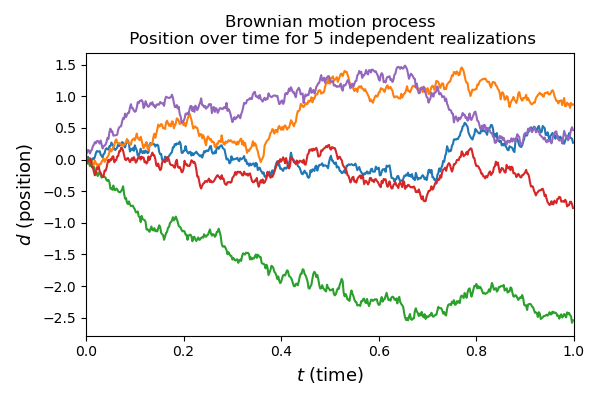

In [2]:
%matplotlib notebook

# 1D simulation of the Brownian motion process
total_time = 1 # total time
nb_steps = 500  # number of timesteps
delta_t = total_time / nb_steps # value of timestep
nb_processes = 5 # Simulate 5 different motions
mean = 0  # Mean of each movement
stdev = np.sqrt(delta_t)  # Standard deviation of each movement

# Simulate the brownian motions in a 1D space by cumulatively
#  making a new movement delta_d
positions = np.cumsum(
    # Move randomly from current location to N(0, delta_t)
    np.random.normal(
        mean, stdev, (nb_processes, nb_steps)),
    axis=1)

plt.figure(figsize=(6, 4))
# Make the plots
t = np.arange(0, total_time, delta_t)
for i in range(nb_processes):
    plt.plot(t, positions[i,:])
#     plt.plot(t, positions[i,:], alpha=0.1) # use this if you change nb_processes = 500
#     then you will see that many functions are centered around 0 (the mean)
#     the more you move away from the mean the less common the functions become
#     this is what is means to have a (normal) distribution over functions
plt.title((
    'Brownian motion process\n '
    'Position over time for 5 independent realizations'))
plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.xlim([-0, 1])
plt.tight_layout()
plt.show()
#

#### Code Walk-through
First we define the total time of the simulation, the number of steps, the timestep ($\Delta t$), and number of particle paths ([realizations](https://en.wikipedia.org/wiki/Realization_%28probability%29)) to plot. Finally we define the mean and standard deviation of normal distribution from which we can sample one random variable $\Delta d$, written as

$$
\Delta d \sim \mathcal{N} \left( 0,\Delta t \right)
$$

This equation means we sample from a univariate normal distribution with a mean of 0 and variance of $\Delta t$. Of course, we could have chosen a different mean or standard deviation/variance for the distribution which would have affected the $\Delta d$ values and thus the paths of the particles.
To get the positions of each particle after a period of time, we do a cumulative sum over the $\Delta d$ values that are sampled from the above distribution.

If we want to sample many independent random variables $\Delta d_n$ at once, we can sample from a multivariate normal distribution that has the same mean (in this case a mean vector) and the same variance (in the form of a covariance matrix). 

$$
\begin{align*}
\begin{bmatrix} \Delta d_1 \\ \Delta d_2 \\ \vdots \\ \Delta d_n
\end{bmatrix}
\sim \mathcal{N}
\left (
\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}
,
\begin{bmatrix} var \Delta d_1 & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & var \Delta d_n \end{bmatrix}
\right)
\end{align*}
$$

This is the same as sampling from a standard normal multivariate distribution with a covariance matrix $\mathbf I_d$ where d is the dimensionality, except that in this case instead of the diagonal having a variance of 1, it is multiplied by a value $\Delta t$ to give the variance of $\Delta d$. Notice that all the off-diagonal values are 0 because there is no covariance between two $\Delta d$ variables.

We can have infinitely many realizations of this stochastic process, and all the realizations are going to have similar properties because the random variables $\Delta d$ are sampled from the same multivariate distribution. Therefore, we can think of a stochastic process as a distribution over functions, which is what a Gaussian Process (GP) is.

Not all random variables are [independent](https://en.wikipedia.org/wiki/Independence_(probability_theory)) of each other. When there is a dependency between random variables, we can exploit that to be able to predict the distribution of one random variable based on another. This dependency is embedded in the covariance matrix in the form of covariance between each two random variables. In Gaussian Process Regression (GPR), we define how two output values depend on each other (i.e. we define how the covariance matrix is evaluated) by kernel functions.

## GPR Kernels

In Gaussian Process Regression (GPR), a kernel function expresses how output values are related to one another.

The most common kernels used is the radial basis function (RBF) kernel, also known as the squared exponential (SE) kernel. It is written as 

$$
SE(\textbf {x},\textbf {x'}) = \sigma^2\exp\left({-\frac{1}{2}\frac{(\textbf {x} - \textbf {x'})^2}{l^2}}\right)
$$

where $\textbf {x}$ and $\textbf {x'}$ are two input vectors, $\sigma^2$ is the variance, and $l$ is the lengthscale. The lengthscale determines how smooth the functions in a Gaussian Process are (i.e. how fast they change in space/time). The variance determines average distance from the function's mean and is just a scaling factor which is sometimes omitted.

There are many kernels to choose from, a list can be found in the [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/). 

**It is important to note that adding or multiplying two kernels together results in a new kernel**. This means kernels can be mixed and matched to find one that best fits your data. Finding an optimal kernel is still an active area of research and an automated selection process has been outlined in the [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/).

To improve the SE kernel, a SE automatic relevance detection (SE-ARD) kernel can be constructed as a product of many SE kernels

$$
SE-ARD(\textbf {x},\textbf {x'}) =\prod_{d=1}^{D} {\sigma_d^2\exp\left({-\frac{1}{2}\frac{(x_d - x_d')^2}{l_d^2}}\right)} = {\sigma_f^2\exp\left({-\frac{1}{2}\sum_{d=1}^{D}\frac{(x_d - x_d)^2}{2l_d^2}}\right)}
$$

What this does is it defines a lengthscale $l_d$ for each dimension $d$ of the input vectors $\textbf {x}$ and $\textbf{x'}$. If changing one dimension of the input vector does not result in changes to the outputs it would suggest using a longer lengthscale along that dimension and vise versa.


# The Prior Distribution

The prior distribution is a distribution over functions, which expresses one's beliefs about the outputs **before** making any observations (before you have observed any data).

## How to Construct the Prior

To make the prior, we will need to make an $n$-dimensional vector of input values from which we can calculate a $n$ x $n$ covariance matrix. We can then sample a random vector of values (I'll call this vector $\mathbf Z$) from a $n$-dimensional standard normal multivariate distribution that is going to correspond to our $n$ number of inputs. We can write this as

$$
\begin{align*}
\begin{bmatrix} \mathbf{Z_1} \\ \mathbf{Z_2} \\ \vdots \\ \mathbf{Z_n}
\end{bmatrix}
\sim \mathcal{N}
\left (
\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}
,
\begin{bmatrix} 1 & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & 1 \end{bmatrix}
\right)
\end{align*}
$$

The last thing to do is to transform this random vector $\mathbf Z$ into a new vector $\mathbf Y$. This new vector $\mathbf Y$ will represent our output values that fit the given criteria selected by our mean vector $\mu + L\begin{bmatrix} \mathbb E \mathbf{Z_1} \\ \mathbb E \mathbf{Z_2} \\ \vdots \\ \mathbb E \mathbf{Z_n} \end{bmatrix}$ and covariance matrix $\Sigma$.

$$
\begin{align*}
\begin{bmatrix} \mathbf{Y_1} \\ \mathbf{Y_2} \\ \vdots \\ \mathbf{Y_n}
\end{bmatrix}
\sim \mathcal{N}
\left (
\mu + L\begin{bmatrix} \mathbb E \mathbf{Z_1} \\ \mathbb E \mathbf{Z_2} \\ \vdots \\ \mathbb E \mathbf{Z_n} \end{bmatrix}
,
\Sigma
\right)
\end{align*}
$$

We will look into how to do this transformation a bit later, for now let's construct the covariance matrix.

## Covariance Matrix ($\Sigma$)

To make the prior distribution, we begin with constructing a covariance matrix. The same approach is used when utilizing other kernels, however it is important that the selected kernel can fit your data well (for example if you know the data is going to be periodic, you should probably select a periodic kernel or combine a periodic kernel with an RBF kernel).  
In this case, an RBF kernel is going to be used to make the matrix.
Let us look at a Python example for a one-dimensional input covariance matrix.

In [3]:
n=100 # number of input points
x=np.linspace(-7,7,n).reshape(n,1) # gives vector of evenly distributed input points

def se_kernel(a, b, sigma,l):
    """definition of SE kernel with lengthscale and variance"""
    dist2 = (a-b.T)**2 # distance squared
    return sigma**2*np.exp(-dist2/(2*l**2))

sigma = 1 # sigma usually stands for standard deviation, variance = stdev^2
l=2 #length scale

K_ss = np.array(se_kernel(x, x, sigma,l))

df = pd.DataFrame(K_ss, index=[f"input{i}" for i in range(1,n+1)], columns = [f"input{i}" for i in range(1,n+1)])

display(df.iloc[:10,:10])

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10
input1,1.000000,0.997503,0.990051,0.977753,0.960793,0.939419,0.913940,0.884717,0.852158,0.816703
input2,0.997503,1.000000,0.997503,0.990051,0.977753,0.960793,0.939419,0.913940,0.884717,0.852158
input3,0.990051,0.997503,1.000000,0.997503,0.990051,0.977753,0.960793,0.939419,0.913940,0.884717
input4,0.977753,0.990051,0.997503,1.000000,0.997503,0.990051,0.977753,0.960793,0.939419,0.913940
input5,0.960793,0.977753,0.990051,0.997503,1.000000,0.997503,0.990051,0.977753,0.960793,0.939419
input6,0.939419,0.960793,0.977753,0.990051,0.997503,1.000000,0.997503,0.990051,0.977753,0.960793
input7,0.913940,0.939419,0.960793,0.977753,0.990051,0.997503,1.000000,0.997503,0.990051,0.977753
input8,0.884717,0.913940,0.939419,0.960793,0.977753,0.990051,0.997503,1.000000,0.997503,0.990051
input9,0.852158,0.884717,0.913940,0.939419,0.960793,0.977753,0.990051,0.997503,1.000000,0.997503
input10,0.816703,0.852158,0.884717,0.913940,0.939419,0.960793,0.977753,0.990051,0.997503,1.000000


#### Code walkthough
First, we generate our inputs, which in this case are 100 evenly spaced values between -7 and 7 inclusive. These values are stored in a vector $\textbf x$. Then we define the SE kernel as discussed previously. In this case, each of the components in $\textbf x$ are one-dimensional inputs (i.e. scalar values), so the SE kernel and the SE-ARD kernel identical. We also specify the standard deviation as "sigma" (standard deviation is square root of variance) and lengthscale to be used. Finally, we create and display the covariance matrix (a [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix) [positive-definite](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix) matrix). **Note**: Only the first 10 rows and columns of the matrix are shown (the whole matrix is a square 100x100 because we selected 100 input values between -7 and 7).


## Relating Outputs to One Another

**The end goal of GPR is to be able to model how outputs relate to one another, based on inputs. Thus, if you know (if you have observed or evaluated) the output at certain input points, you would be able to predict outputs at new input points that you have not seen before.**
So far, we have only been talking about how to construct a covariance matrix from the inputs.
The numbers in the matrix represent the covariance between each two **output** points based on their respective **input** points. In the SE kernel, the covariance between two **output** points decreases as the distance between their respective **input** points increases. You will notice this trend in the covariance matrix above. The covariance values decrease along a row (or column) as the distance between two **input** points increases. A low covariance does not mean that input values that are far away from each other must have different output values. It only suggests that the output values are not related, meaning that you cannot confidently predict an output value at a new input location, based on a known output value that is far away.


When the distance between two points is 0, the covariance between the points essentially becomes the variance of that particular output point. This is because the distance between the two points is 0, thus the exponent part of the kernel is evaluated to 0. Then $\exp^0$ is evaluated to 1, which is then scaled by the variance $\sigma^2$ (again the variance is sometimes omitted from the SE kernel).

## Sampling prior outputs using the covariance matrix

As explained previously, we want have our prior outputs $\mathbf Y$ following this normal distribution
$$
\begin{align*}
\begin{bmatrix} \mathbf{Y_1} \\ \mathbf{Y_2} \\ \vdots \\ \mathbf{Y_n}
\end{bmatrix}
\sim \mathcal{N}
\left (
\mu + L\begin{bmatrix} \mathbb E \mathbf{Z_1} \\ \mathbb E \mathbf{Z_2} \\ \vdots \\ \mathbb E \mathbf{Z_n} \end{bmatrix}
,
\Sigma
\right)
\end{align*}
$$

Instead of directly sampling $\mathbf Y$ from this distribution to get our prior output samples, we can take $n$ number of samples from an  $n$-dimensional standard normal distribution as explained previously, i.e.

$$
\begin{align*}
\begin{bmatrix} \mathbf{Z_1} \\ \mathbf{Z_2} \\ \vdots \\ \mathbf{Z_n}
\end{bmatrix}
\sim \mathcal{N}
\left (
\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}
,
\begin{bmatrix} 1 & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & 1 \end{bmatrix}
\right)
\end{align*}
$$

To transform the vecor $\mathbf Z$ into $\mathbf Y$, we need to compute the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of the covariance matrix so that

$$
\Sigma = LL^T
$$

Then this transofrmation is computed by 

$$
\mathbf Y= L \mathbf Z + \mu
$$

What we are doing essentially is changing the vector $\mathbf Z$ to incorporate how output values covary with each other based on the covariance matrix ($L \mathbf Z$ term) and shifting the outcome by some vector $\mu$. The result is a vector $\mathbf Y$ as if it is sampled from a distribution with mean vector $\mu + L\begin{bmatrix} \mathbb E \mathbf{Z_1} \\ \mathbb E \mathbf{Z_2} \\ \vdots \\ \mathbb E \mathbf{Z_n} \end{bmatrix}$ and covariance matrix $\Sigma$. This is known as an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation).

Check out [this post](https://peterroelants.github.io/posts/multivariate-normal-primer/#Affine-transformations-of-the-multivariate-normal) for explanation.

Below is an example of doing this with Python and finally plotting what the prior looks like.

<IPython.core.display.Javascript object>


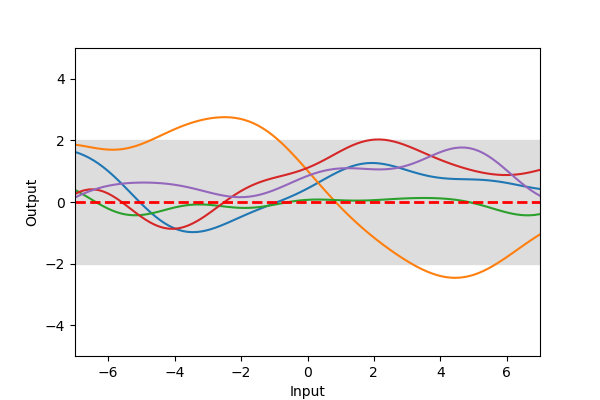

In [4]:
# Prior Distribution using SE kernel
mu = 0
L_ss=np.linalg.cholesky(K_ss + 1e-14*np.eye(n)) # triangular L** matrix from Cholesky decomposition (sort of sqrt of K**)
                                                # + 1e-14*np.eye(n) ensures numerical stability wrt Cholesky

k=5 # number of samples to plot
rand_v=np.random.normal(size=(n,k)) # k n-dimensional vectors from normal distribution N(0,I)
prior = np.dot(L_ss, rand_v) + mu # make a proper normal distribution to sample prior N(0,L)

plt.figure(figsize=(6, 4))
plt.plot(x, prior) # input and output coordinates
plt.plot(x, mu*np.ones(n), 'r--', lw=2) # plot mean, mean=0
plt.axis([-7, 7, -5, 5]) 
plt.gca().fill_between(x.reshape(-1), -2*sigma+mu, 2*sigma+mu, color="#dddddd") # 2 sigma confidence interval around mean, 95%
# plt.title(str(k)+' samples from the GP prior + 2 $\sigma$')
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

plt.savefig("prior.png")

### Code Walkthtough

To construct the visual, we first use [Cholesky Decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) to decompose our covariance matrix into two triangular matrices (Cholesky decomposition splits a symmetric matrix $A$ into $L$ and $L^T$). Notice that we add a very small number to the diagonal of the covariance matrix. This addition is known as the *jitter* and it is used to prevent a matrix from being numerically [ill-conditioned](https://en.wikipedia.org/wiki/Condition_number). The bigger the matrix is, the bigger number you need to add to the diagonal. Then we use numpy's random.normal method to get 5 random vectors, containing numbers sampled from a standard normal multivariate distribution. Vectors generated this way are known as standard normal vectors. By finding the dot product between the lower triangular matrix $L$ and the standard normal vectors, after which we add a mean vector $\mu$, we generate 5 normal random vectors (corresponding to 5 sampled $\mathbf Y$ vectors that agree with the given covariance matrix). In this case, we assume a $\mu$ vector of 0 (as "mu" is set to 0 in the above code). Read up on these types of vectors on Wikipedia's [Multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Standard_normal_random_vector) Wikipedia page.


So now we have 5 normal random vectors that can serve as output values for our 1 dimensional input GP. The only thing left to do is to plot. We plot our input and output values, creating 5 sampled functions from our distribution of functions. We also plot our prior mean function as a dashed red line. The mean function represents the expected value of the function at a particular input point. Finally, we plot the confidence of our GP by filling between $-2\sigma$ and $+2\sigma$. We are essentially filling the region in which we expect 95% of output values to lie. In theory, our GP has infinitely many output points (so they can be expressed as a function) and we can draw infinitely many sample functions, but we cannot plot infinitely many things with matplotlib but we can use a distribution instead!  Notice that if you rerun the script a couple of times, some functions will have output values outside of the 95% confidence interval. Also notice that although each sampled function has a different output value at one input point, it is expected that the output values of all functions averages out to the output mean at that particular input point.

The variance $\sigma^2$ from the SE kernel determines the vertical variation of the GP. A high variance will give very large confidence intervals (meaning that your outputs can lie in a very large range of values). This is not ideal because it means your model will be more uncertain on where the output values are. A small variation means that the outputs can lie in a tighter range of values (therefore the distribution will be narrower). This will be brought up again when we construct the posterior distribution. The lengthscale determines how fast the covariance between two output points drops off. A short lengthscale means that covariance between two points decreases fast and a long lengthscale means covariance between two points decreases slowly (across a row or column). Change the variable "l" in the above script to see the impact it has on the covariance matrix values (and visual representation of functions). Check out the article [A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/) for very good visual representations of lengthscale and variance for various kernels.

This prior represents the beliefs we have about the data we are going to model **before** seeing any observations. We incorporate those prior beliefs in the kernel that we chose before. With an SE kernel, we get smooth functions, noting that all functions in the GP have similar properties (they look similar visually). If our data was expected to have periodicity, we might chose a periodic kernel (or make our own custom kernel by multiplying or adding kernels together).
Let's look at how to construct the posterior distribution now.

## The Posterior Distribution

The posterior distribution is constructed by inserting observed data into the GP, thus restricting the prior distribution to functions that fit our observed data. The observed outputs $\textbf y$ and the test outputs $\mathbf{f}_*$ (unknown outputs for which we want to predict values) are [jointly Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Joint_normality), meaning they come from the same Gaussian distribution. This distribution is written as 

$$
\begin{bmatrix} \mathbf{y} \\ \mathbf{f}_* \end{bmatrix} = \mathcal{N}\left(
\begin{bmatrix}\mathbb E \mathbf{y} \\ \mathbb E \mathbf{f}_* \end{bmatrix} ,
\begin{bmatrix} K(X, X)  + \sigma_n^2I && K(X, X_*) \\ K(X_*, X) && K(X_*, X_*)\end{bmatrix}\right)
$$

where mean vector $\begin{bmatrix}\mathbb E \mathbf{y} \\ \mathbb E \mathbf{f}_* \end{bmatrix}$ is usually set to $\mathbf 0$ for simplicity. There are 4 sub-matrices of the covariance matrix: $K(X,X)+\sigma_n^2I$ representing covariance between observed output points, $K(X_*, X)$ representing covariance between test outputs and training outputs, $K(X, X_*)$ representing covariance between training outputs and test outputs (transpose of $K(X_*, X)$), and finally $K(X_*, X_*)$ representing covariance between test outputs and test outputs. All of these matrices are computed by applying the kernel function on the corresponding inputs. The sub-matrices $K(X,X)$ and $K(X_*, X_*)$ are always square matrices, while the other two can be rectangular. In our case, the $K(X_*, X_*)$ matrix has already been computed when we constructed the prior for the 100 points between -7 and 7.

We already know how the outputs are going to vary in the -7 to 7 region because we have computed the covariance matrix in that region (K_ss in Python code). We just need some data now to be able to predict the outputs in that region based on the data we put into the GP. Notice that $\sigma_n^2I$ is an additional term that can be *optionally* added to $K(X, X)$. It represents noise added to the observations. It is assumed this noise is independent and identically distributed for each observation, so it is only added to the diagonal of the covariance matrix(it does not affect covariance but only affects variance).

## Computing Predictions 

The GP posterior is found by conditioning the joint G.P prior distribution given the observations, so it is a [conditional distribution](https://peterroelants.github.io/posts/multivariate-normal-primer/#Conditional-distribution) written as 
$$p(\mathbf{f}_* | X_*, X, \mathbf{y}) \sim \mathcal{N}\left(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*)\right),$$
where 
$$
\begin{align*}
\bar{\mathbf{f}}_* &= K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y} \\
\text{cov}(\mathbf{f}_*) &= K(X_*, X_*) - K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}K(X, X_*)
\end{align*}
$$

$\mathbf{f}_*$ is the conditional mean vector (which contains the predictions of the output values at the test points) and the $\text{cov}(\mathbf{f}_*)$ is the conditional covariance matrix which contains the variance of the posterior GP along the diagonal. This variance at each test output point shows how confident the model is in predictions, which is one advantage Gaussian Process Regression has over other machine learning methods. Derivations for the conditional distribution can be seen [here](https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution).

Finding the inverse matrix $\left[K(X, X) + \sigma_n^2\right]^{-1}$ becomes more and more computationally expensive as the matrix grows with each training point that is added. Therefore, Cholesky decomposition can be utilized to speed up the process. It is utilized in the following way:


$$
\bar{\mathbf{f}}_* = K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y}
$$

$$
\begin{align*}
\left[K(X, X) + \sigma_n^2\right] \mathbf x &= \left[K(X, X) + \sigma_n^2\right] \left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y} \\
LL^T \mathbf x &= \mathbf{y} \\
L\mathbf z &=  \mathbf{y} \\
L^T \mathbf x &= \mathbf z
\end{align*}
$$ 

which is more directly written as 

$$
\begin{align*}
\alpha &= \left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y} \\
\alpha &= L^T \backslash (L \backslash y)
\end{align*}
$$

This can be solved easily because $L$ and $L^T$ are lower and upper triangular matrices (can use forward/back substitution).
Therefore $\bar{\mathbf{f}}_*$ becomes
$$
\bar{\mathbf{f}}_* = K(X_*, X)\alpha
$$

Moving on to the conditional covariance matrix at the test points:

$$
\text{cov}(\mathbf{f}_*) = K(X_*, X_*) - K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}K(X, X_*)
$$

$$
\begin{align*}
\mathbf{v} &= L^T [K(X, X) + \sigma_n^2]^{-1}K(X, X_*) \\
\mathbf{v} &= L \backslash K(X, X_*) \\ 
\mathbf{v}^T &= K(X, X_*)^T\left[\left[K(X, X) + \sigma_n^2\right]^{-1}\right]^T\left[L^T\right]^T
\end{align*}
$$

$$
\begin{align*}
\mathbf{v}^T\mathbf{v} &= K(X, X_*)^T\left[\left[K(X, X) + \sigma_n^2\right]^{-1}\right]^T\left[L^T\right]^TL^T \left[K(X, X) + \sigma_n^2\right]^{-1}K(X, X_*) \\
&= K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}LL^T \left[K(X, X) + \sigma_n^2\right]^{-1}K(X, X_*) \\
&= K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}\left[K(X, X) + \sigma_n^2\right]\left[K(X, X) + \sigma_n^2\right]^{-1}K(X, X_*) \\
&= K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}K(X, X_*)
\end{align*}
$$


$$
\text{cov}(\mathbf{f}_*) = K(X_*, X_*) - \mathbf{v}^T\mathbf{v}
$$



<IPython.core.display.Javascript object>


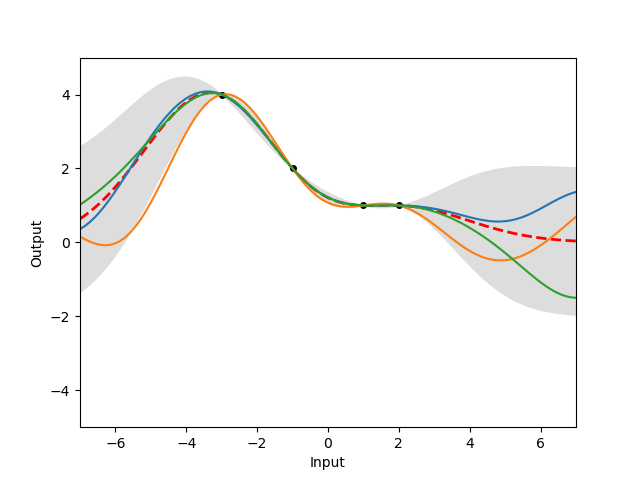

In [5]:
x_train = np.array([-1,2,-3,1]).reshape(-1,1) # 4 training points x
y_train = np.array([2,1,4,1]).reshape(-1,1) #  4 observed output values at training points

noise = 0.00*np.eye(x_train.shape[0]) #change to 0.05*np.eye(x_train.shape[0]) for added Gaussian noise

K = se_kernel(x_train, x_train, sigma,l) + noise # K(X,X) 4 x 4 covariance matrix for training using previously definsed se_kernel
L = np.linalg.cholesky(K)

K_s = se_kernel(x, x_train, sigma,l) # K(X*,X) Covariance between training points x_train and 'test points' x* from prior.

alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
v = np.linalg.solve(L,K_s.T)

posterior_mu = np.dot(K_s, alpha).reshape(-1) # mean of the posterior, containing predictions
posterior_cov = K_ss - np.dot(v.T,v) # cov(f*)

# Compute variance from posterior covariance matrix (diagonal)
var = np.diag(posterior_cov).reshape(-1) # diagonal of the posterior covariance matrix
stdv = np.sqrt(var).reshape(-1) # standard deviations as elementwise sqrt of variance

# create sample functions that fit posterior covariance matrix
L_posterior = np.linalg.cholesky(posterior_cov + 1e-13*np.eye(n)) # Cholesky decomposed posterior covariance L
posterior_samples = posterior_mu.reshape(-1,1) + np.dot(L_posterior, np.random.normal(size=(n,3))) # sampling posteirior with mean mu and posterior cov matrix 

plt.figure()
plt.gca().fill_between(x.reshape(-1), posterior_mu-2*stdv, posterior_mu+2*stdv, color="#dddddd") # 2 sigma confidence interval fill
plt.plot(x.reshape(-1), posterior_mu, 'r--', lw=2) # posterior mean
plt.plot(x_train, y_train, 'ko', ms=4) # training points
plt.axis([-7, 7, -5, 5])
plt.plot(x, posterior_samples) # posterior samples
plt.xlabel("Input")
plt.ylabel("Output")
# plt.title('GP posterior')
plt.show()

plt.savefig("posterior.png")

### Code Walk-through

We define the training inputs and training outputs (x\_train and y\_train respectively). Then we compute $K(X,X)$ and decompose it with Cholesky decomposition. Optionally we can add noise to the observed outputs with the "noise" variable. We compute the $K(X_*,X)$ matrix, thus we also known its transpose $K(X,X_*)$. We already have a $K(X_*,X_*)$ as we have computed it previously in the prior, so we'll just use it here. Now that we have the 4 sub-matrices, we compute $\alpha$ and $\mathbf v$ as described previously. Thus, we can also compute the posterior mean and posterior covariance matrix. The variance of the posterior is the diagonal of the covariance matrix so we can extract that and find the square root, thus finding the standard deviations at each test output point. Finally, we make 3 sampled functions that fit our posterior by the same method which we used to sample the prior distribution (i.e. we perform Cholesky decomposition of the posterior covariance matrix $\text {cov}(\mathbf f_*)$) and find the dot product between the resulting matrix and an $n$-dimensional *standard* normal multivariate vector. Lastly we can plot everything. The gray area indicates the 95% confidence interval (calculated by 2 * the standard deviations from the diagonal variances).

As you can see, when we have training data, the gray area is very narrow (our variance and standard deviations are low), so the model has high confidence in predicting in this area. As we move away from the training points, the posterior distribution eventually falls back to the prior distribution. This is because there is no information in a region with no training data, so the model is not confident in predictions.
**NOTE: The prior itself is never constructed explicitly like we did in this notebook (for demonstration purposes). When we define a covariance kernel we are already defining the prior in the n-dimensional space we are working in and we just need to update it with data we feed into the GP. Only the 4 sub-matrices need to be constructed and calculations at unknown output points can be performed.**

## Predicting outputs at new test points

Although we have already predicted outputs when we constructed the posterior figure previously, I just want to go through the process again, computing the predicted output for 1 test point. (you can scale this for many test points if you want to, the process of predicting is the same).

Let's say we have training points 
$$
\begin{align*}
x &= (-1,2) \\
y&= (2,1)
\end{align*}
$$

where x are your observed/training inputs and y are observed outputs. If we want to predict the output value at input 0, we would need to construct the 4 matrices as discussed previously.

In [6]:
sigma = 1 # defined in previous code block, jut copying them again here
l = 2 # defined in previous code block, jut copying them again here

x_train = np.array([-1,2]).reshape(-1,1) # 2 training points x
y_train = np.array([2,1]).reshape(-1,1) #  2 observed output values at training points
x_test = np.array([0]).reshape(-1,1) # 1 test point containing input at 0

# constructing the covaraince matrices
K = se_kernel(x_train, x_train, sigma,l) # training point-training point K(X,X)
K_s = se_kernel(x_test, x_train, sigma,l) # test point-training point K(X*, X)
K_s_transpose = K_s.T # only for demonstration
#usually don't have to store transposed matrix as you can transpose the original matrix when needed, saves memory
K_ss = se_kernel(x_test, x_test, sigma,l) # covariance between test point - test point (in this case only one test point)


Alright we have the 4 matrices, the multivariate distribution looks something like this now, the 4 matrices are separated for clarity.

$$
\begin{bmatrix} 2 \\ 1 \\ \mathbf {f}_* \end{bmatrix} \sim \mathcal{N}\left(
\mathbf 0,
\begin{bmatrix}
\begin{bmatrix} 1 && 0.325 \\ 0.325 && 1 \end{bmatrix} && \begin{bmatrix} 0.882 \\ 0.606 \end{bmatrix} 
\\
\begin{bmatrix} .882 && 0.606 \end{bmatrix} && \begin{bmatrix} 1 \end{bmatrix}
\end{bmatrix}\right)
$$

so now we just compute $\bar{\mathbf{f}}_*$ and $\text{cov}(\mathbf{f}_*)$ as before.

In [7]:
L = np.linalg.cholesky(K)

alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
fs_mu = np.dot(K_s, alpha).reshape(-1) # vector of predicted output values at test points (in this case only 1 dimensional)

print ("Predicted value/s")
print(fs_mu)

v = np.linalg.solve(L,K_s.T)
posterior_cov = K_ss - np.dot(v.T,v) # cov(f*)
# for one test point the posterior covariance will just be a number
# corresponding to the variance of the GP at that test point

var = np.diag(posterior_cov).reshape(-1) # diagonal of the posterior covariance matrix
print ("The variance at the predicted value/s:")
print (var)
stdv = np.sqrt(var).reshape(-1) # standard deviations as elementwise sqrt of variance
print ("The standard deviation at the predicted value/s:")
print (stdv)

Predicted value/s
[1.89044808]
The variance at the predicted value/s:
[0.10671625]
The standard deviation at the predicted value/s:
[0.32667453]


## Bayes' Theorem

To wrap up, here is a small introduction to how Bayes' Theorem is related to Gaussian Process Regression. Bayes' Theorem is usually written as

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

Where $P(A|B)$ is known as the **posterior**, $P(B|A)$ is the **likelihood**, $P(A)$ is the **prior**, and $P(B)$ is the total probability of $B$.

When you see something like $P(A|B)$, it is read as "the probability of A given B". This type of probability is also referred to as conditional probability because the probability of $A$ is **conditioned** on $B$.

Essentially what you are doing with Bayesian reasoning is you are updating your *prior* beliefs (i.e. $P(A)$) based on the data you are seeing to get your *posterior* beliefs $P(A|B)$.

[This video](https://www.youtube.com/embed/HZGCoVF3YvM) by 3Blue1Brown explains the concept visually very well.

## Resources
### Here is a list of resources I used to make this notebook and learn the basics of GPs myself

1. [peterroelants.github.io](https://peterroelants.github.io/posts/gaussian-process-tutorial/)

1. [Practical GP Regression](https://gregorygundersen.com/blog/2019/09/12/practical-gp-regression/)

1. [krasserm.github.io](http://krasserm.github.io/2018/03/19/gaussian-processes/)

1. [michaeloneill.github.io](https://michaeloneill.github.io/GPR-tutorial.html)

1. [A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)

1. [Gaussian Processes for Dummies](https://katbailey.github.io/post/gaussian-processes-for-dummies/)

1. [The Significance and Applications of Covariance Matrix](https://towardsdatascience.com/the-significance-and-applications-of-covariance-matrix-d021c17bce82)

1. [A Practical Implementation of Gaussian Process Regression](https://gregorygundersen.com/blog/2019/09/12/practical-gp-regression/)

1. [Quick Start to Gaussian Process Regression](https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319)

1. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/RW.pdf)

1. [Surrogates](https://bookdown.org/rbg/surrogates/chap5.html)

1. specifics on mean, standard deviation, variance can be found in [this video](https://youtu.be/JIIXQaMXBVM).